# Giant component analysis

In [1]:
import os
from raphtory import Graph

# Specify the file path
binecode_path = "C:/ms_bincode/Graph_3"

# Load the file
if os.path.isfile(binecode_path):
    g = Graph.load_from_file(binecode_path)
    print(g)
else:
    print(f"File does not exist: {binecode_path}")

Graph(number_of_edges=97252, number_of_vertices=26533, number_of_temporal_edges=159288593, earliest_time="7200000", latest_time="10799999")


# Get the giant component

In [10]:
from collections import Counter
from raphtory import algorithms as rp

# Run a community detection algorithm which checks lcc in the graph
lcc =  rp.weakly_connected_components(g)

# Make it a dictionary
components_dict = lcc.get_all()

# Count the frequency of each component ID
component_sizes = Counter(components_dict.values())

# Find the top ten giant component
gc = component_sizes.most_common(1)

# Create a list to hold names of the nodes in the gc
gc_nodes = []

# Populate the list
for name, component_id in components_dict.items():
    if component_id == gc[0][0]:
        gc_nodes.append(name)

# Make a subgraph
gc_subgraph = g.subgraph(gc_nodes)
gc_subgraph

Graph(number_of_edges=96944, number_of_vertices=26097, number_of_temporal_edges=159125797, earliest_time="7200000", latest_time="10799999")

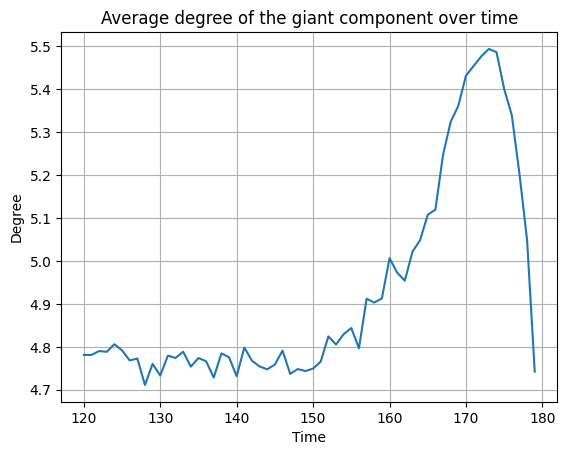

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

"""
Diagram which gives the average degree of the giant component over time
"""

num_temp_edges = []
time = []

for windowed_graph in gc_subgraph.rolling(window=60000):
    result = rp.average_degree(windowed_graph)
    num_temp_edges.append(result)
    time_in_minutes = windowed_graph.earliest_time / 60000
    time.append(time_in_minutes)

plt.plot(time, num_temp_edges)
plt.xlabel("Time")
plt.ylabel("Degree")
plt.title("Average degree of the giant component over time")
plt.grid(True)

# Get the nodes with the highest number of out degrees in the one hour subgraph

In [13]:
# 1. Retrieve all nodes and their out-degrees
nodes_out_degrees = [(node.name, node.out_degree()) for node in gc_subgraph.vertices]

# 2. Sort nodes by their out-degree in descending order
sorted_nodes = sorted(nodes_out_degrees, key=lambda x: x[1], reverse=True)

# 3. Select the top 10 nodes
top_10_nodes = sorted_nodes[:20]

# Print names and out-degrees of the top 10 nodes
for name, out_degree in top_10_nodes:
    print(f"Node Name: {name}, Out-Degree: {out_degree}")

Node Name: USER, Out-Degree: 3258
Node Name: MS_45285, Out-Degree: 456
Node Name: MS_39211, Out-Degree: 445
Node Name: MS_25557, Out-Degree: 374
Node Name: MS_745, Out-Degree: 252
Node Name: MS_39564, Out-Degree: 237
Node Name: MS_15934, Out-Degree: 230
Node Name: MS_4990, Out-Degree: 219
Node Name: MS_53695, Out-Degree: 190
Node Name: MS_71138, Out-Degree: 175
Node Name: MS_44698, Out-Degree: 139
Node Name: MS_3533, Out-Degree: 131
Node Name: MS_54865, Out-Degree: 125
Node Name: MS_4660, Out-Degree: 117
Node Name: MS_3311, Out-Degree: 114
Node Name: MS_31008, Out-Degree: 108
Node Name: MS_66850, Out-Degree: 101
Node Name: MS_60860, Out-Degree: 100
Node Name: MS_44065, Out-Degree: 96
Node Name: MS_47558, Out-Degree: 95


# Get the nodes with the highest number of out degrees during the spike

In [14]:
start_time = 10200000 # Minute 170
end_time = 10200000 + 120000 # Minute 172

g_spike = gc_subgraph.window(start_time, end_time)

print(g_spike)

# 1. Retrieve all nodes and their out-degrees
nodes_out_degrees = [(node.name, node.out_degree()) for node in g_spike.vertices]

# 2. Sort nodes by their out-degree in descending order
sorted_nodes = sorted(nodes_out_degrees, key=lambda x: x[1], reverse=True)

# 3. Select the top 10 nodes
top_10_nodes = sorted_nodes[:20]

# Print names and out-degrees of the top 10 nodes
for name, out_degree in top_10_nodes:
    print(f"Node Name: {name}, Out-Degree: {out_degree}")

Graph(number_of_edges=43274, number_of_vertices=14424, number_of_temporal_edges=6570379, earliest_time="10200000", latest_time="10319999")
Node Name: USER, Out-Degree: 1648
Node Name: MS_45285, Out-Degree: 219
Node Name: MS_39211, Out-Degree: 214
Node Name: MS_25557, Out-Degree: 206
Node Name: MS_15934, Out-Degree: 142
Node Name: MS_745, Out-Degree: 130
Node Name: MS_39564, Out-Degree: 127
Node Name: MS_4990, Out-Degree: 109
Node Name: MS_54865, Out-Degree: 93
Node Name: MS_4660, Out-Degree: 90
Node Name: MS_64512, Out-Degree: 78
Node Name: MS_66850, Out-Degree: 71
Node Name: MS_60860, Out-Degree: 70
Node Name: MS_3311, Out-Degree: 70
Node Name: MS_44698, Out-Degree: 69
Node Name: MS_8811, Out-Degree: 61
Node Name: MS_68238, Out-Degree: 58
Node Name: MS_18249, Out-Degree: 57
Node Name: MS_44065, Out-Degree: 55
Node Name: MS_31008, Out-Degree: 55


# Compare the nodes' out degree values during the spike and outside the spike

In [15]:
start_time = 7800000 # Minute 130
end_time = 7800000 + 120000 # Minute 132

g_no_spike = gc_subgraph.window(start_time, end_time)

# Retrieve all nodes in the second subgraph as a dictionary for quick access
nodes_in_no_spike = {node.name: node for node in g_no_spike.vertices}

# Initialize a list to store the comparison results
comparison_results = []

# Iterate over the top 10 nodes identified in the first subgraph
for name, spike_out_degree in top_10_nodes:
    # Check if the node exists in the second subgraph
    if name in nodes_in_no_spike:
        # Retrieve the node's out-degree in the second subgraph
        new_out_degree = nodes_in_no_spike[name].out_degree()
        # Store the comparison
        comparison_results.append((name, spike_out_degree, new_out_degree))
    else:
        # If the node doesn't exist in the second subgraph, note it as not found
        comparison_results.append((name, spike_out_degree, "Not found in second subgraph"))

# Print the comparison results
for name, spike_out_degree, new_out_degree in comparison_results:
    print(f"Node Name: {name}, Out-Degree during the spike: {spike_out_degree}, Out-Degree: {new_out_degree}")

Node Name: USER, Out-Degree during the spike: 1648, Out-Degree: 1628
Node Name: MS_45285, Out-Degree during the spike: 219, Out-Degree: 98
Node Name: MS_39211, Out-Degree during the spike: 214, Out-Degree: 42
Node Name: MS_25557, Out-Degree during the spike: 206, Out-Degree: 55
Node Name: MS_15934, Out-Degree during the spike: 142, Out-Degree: 39
Node Name: MS_745, Out-Degree during the spike: 130, Out-Degree: 134
Node Name: MS_39564, Out-Degree during the spike: 127, Out-Degree: 131
Node Name: MS_4990, Out-Degree during the spike: 109, Out-Degree: 122
Node Name: MS_54865, Out-Degree during the spike: 93, Out-Degree: 86
Node Name: MS_4660, Out-Degree during the spike: 90, Out-Degree: 34
Node Name: MS_64512, Out-Degree during the spike: 78, Out-Degree: 59
Node Name: MS_66850, Out-Degree during the spike: 71, Out-Degree: 70
Node Name: MS_60860, Out-Degree during the spike: 70, Out-Degree: 67
Node Name: MS_3311, Out-Degree during the spike: 70, Out-Degree: 41
Node Name: MS_44698, Out-Degr

# Create a diagram showing the comparison

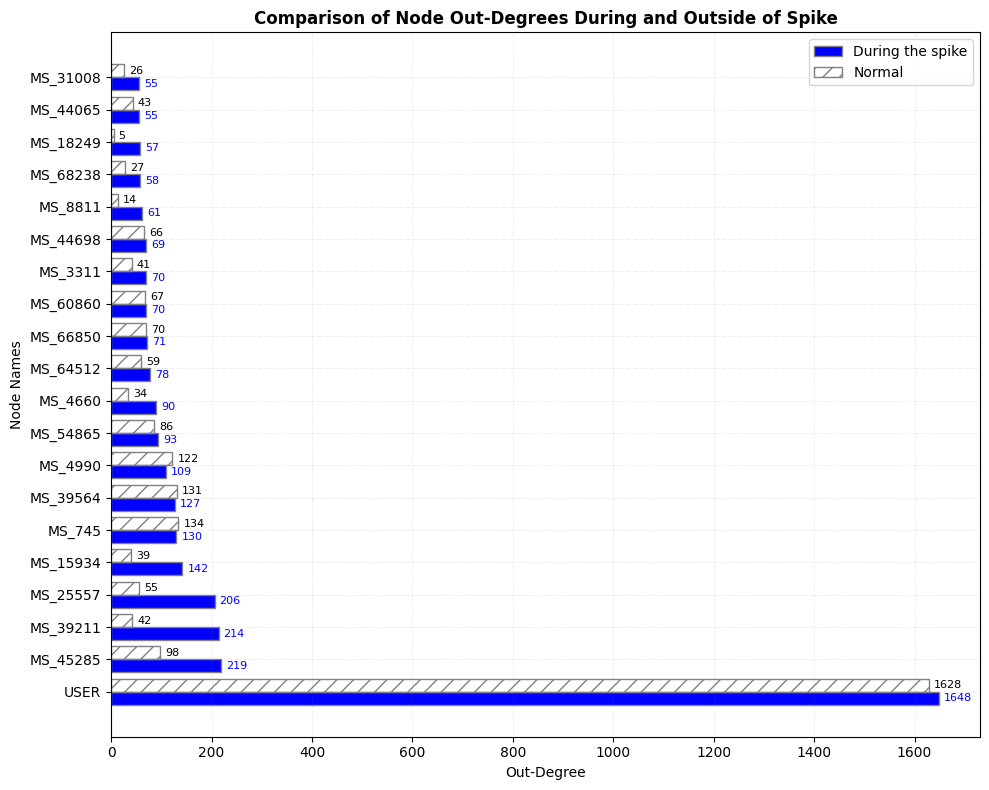

In [18]:
import matplotlib.pyplot as plt
import numpy as np
names = []
spike_out_degrees = []
normal_out_degrees = []

for name, spike_out_degree, new_out_degree in comparison_results:
    names.append(name)
    spike_out_degrees.append(spike_out_degree)
    normal_out_degrees.append(new_out_degree)

fig, ax = plt.subplots(figsize=(10, 8))
r = np.arange(len(names))
r1 = r
r2 = [x + 0.4 for x in r]

# Make the plot
ax.barh(r1, spike_out_degrees, color='blue', height=0.4, label='During the spike', edgecolor='grey')
ax.barh(r2, normal_out_degrees, color='none', height=0.4, label='Normal', edgecolor='grey', hatch='//')

# Add x,y gridlines
ax.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

# Add annotation to bars
for i in range(len(names)):
    # Positioning the text on the right end of the bar
    ax.text(spike_out_degrees[i] + 10, i, str(spike_out_degrees[i]), va='center', color='blue', fontsize=8)
    ax.text(normal_out_degrees[i] + 10, i + 0.4, str(normal_out_degrees[i]), va='center', color='black', fontsize=8)

# Add x, y axis labels
plt.xlabel('Out-Degree')
plt.ylabel('Node Names')

# Add legend
plt.legend()

# Add titles and labels
plt.yticks([r + 0.2 for r in range(len(names))], names)
plt.title('Comparison of Node Out-Degrees During and Outside of Spike', fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()

# Comparison for hour #15

Graph(number_of_edges=163169, number_of_vertices=37220, number_of_temporal_edges=267337874, earliest_time="50400000", latest_time="53999999")


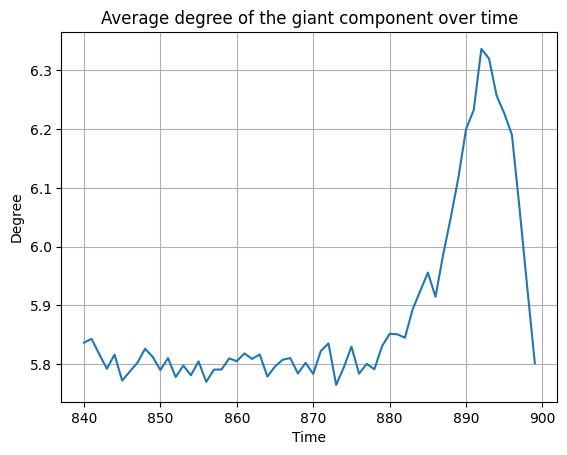

In [1]:
import os
from raphtory import Graph
from collections import Counter
from raphtory import algorithms as rp
import matplotlib.pyplot as plt
import pandas as pd

# Specify the file path
binecode_path = "C:/ms_bincode/Graph_15"

# Load the file
if os.path.isfile(binecode_path):
    g = Graph.load_from_file(binecode_path)
    print(g)
else:
    print(f"File does not exist: {binecode_path}")

# Run a community detection algorithm which checks lcc in the graph
lcc =  rp.weakly_connected_components(g)

# Make it a dictionary
components_dict = lcc.get_all()

# Count the frequency of each component ID
component_sizes = Counter(components_dict.values())

# Find the top ten giant component
gc = component_sizes.most_common(1)

# Create a list to hold names of the nodes in the gc
gc_nodes = []

# Populate the list
for name, component_id in components_dict.items():
    if component_id == gc[0][0]:
        gc_nodes.append(name)

# Make a subgraph
gc_subgraph = g.subgraph(gc_nodes)
gc_subgraph

"""
Diagram which gives the average degree of the giant component over time
"""

num_temp_edges = []
time = []

for windowed_graph in gc_subgraph.rolling(window=60000):
    result = rp.average_degree(windowed_graph)
    num_temp_edges.append(result)
    time_in_minutes = windowed_graph.earliest_time / 60000
    time.append(time_in_minutes)

plt.plot(time, num_temp_edges)
plt.xlabel("Time")
plt.ylabel("Degree")
plt.title("Average degree of the giant component over time")
plt.grid(True)

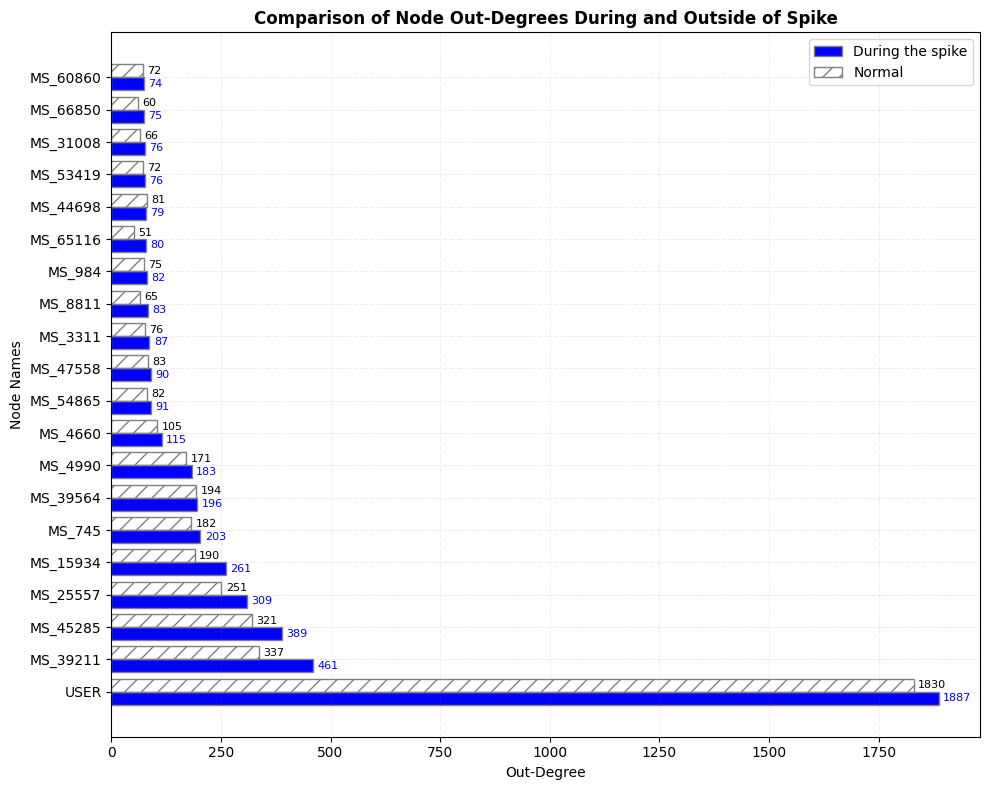

In [7]:
import numpy as np

start_time = 53460000 # Minute 891
end_time = 53460000 + 120000 # Minute 893

g_spike = gc_subgraph.window(start_time, end_time)

# 1. Retrieve all nodes and their out-degrees
nodes_out_degrees = [(node.name, node.out_degree()) for node in g_spike.vertices]

# 2. Sort nodes by their out-degree in descending order
sorted_nodes = sorted(nodes_out_degrees, key=lambda x: x[1], reverse=True)

# 3. Select the top 10 nodes
top_10_nodes = sorted_nodes[:20]

start_time = 51000000 # Minute 850
end_time = 51000000 + 120000 # Minute 852

g_no_spike = gc_subgraph.window(start_time, end_time)

# Retrieve all nodes in the second subgraph as a dictionary for quick access
nodes_in_no_spike = {node.name: node for node in g_no_spike.vertices}

# Initialize a list to store the comparison results
comparison_results = []

# Iterate over the top 10 nodes identified in the first subgraph
for name, spike_out_degree in top_10_nodes:
    # Check if the node exists in the second subgraph
    if name in nodes_in_no_spike:
        # Retrieve the node's out-degree in the second subgraph
        new_out_degree = nodes_in_no_spike[name].out_degree()
        # Store the comparison
        comparison_results.append((name, spike_out_degree, new_out_degree))
    else:
        # If the node doesn't exist in the second subgraph, note it as not found
        comparison_results.append((name, spike_out_degree, "Not found in second subgraph"))

names = []
spike_out_degrees = []
normal_out_degrees = []

for name, spike_out_degree, new_out_degree in comparison_results:
    names.append(name)
    spike_out_degrees.append(spike_out_degree)
    normal_out_degrees.append(new_out_degree)

fig, ax = plt.subplots(figsize=(10, 8))
r = np.arange(len(names))
r1 = r
r2 = [x + 0.4 for x in r]

# Make the plot
ax.barh(r1, spike_out_degrees, color='blue', height=0.4, label='During the spike', edgecolor='grey')
ax.barh(r2, normal_out_degrees, color='none', height=0.4, label='Normal', edgecolor='grey', hatch='//')

# Add x,y gridlines
ax.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

# Add annotation to bars
for i in range(len(names)):
    # Positioning the text on the right end of the bar
    ax.text(spike_out_degrees[i] + 10, i, str(spike_out_degrees[i]), va='center', color='blue', fontsize=8)
    ax.text(normal_out_degrees[i] + 10, i + 0.4, str(normal_out_degrees[i]), va='center', color='black', fontsize=8)

# Add x, y axis labels
plt.xlabel('Out-Degree')
plt.ylabel('Node Names')

# Add legend
plt.legend()

# Add titles and labels
plt.yticks([r + 0.2 for r in range(len(names))], names)
plt.title('Comparison of Node Out-Degrees During and Outside of Spike', fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()

# 24 Hour time data

Graph(number_of_edges=131438, number_of_vertices=31718, number_of_temporal_edges=240747519, earliest_time="82800000", latest_time="86399999")


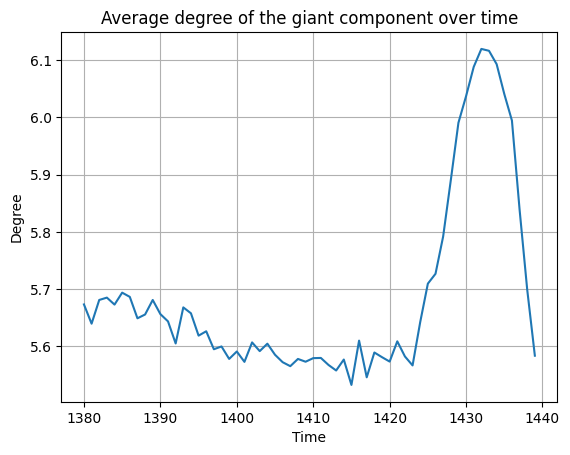

In [8]:
import os
from raphtory import Graph
from collections import Counter
from raphtory import algorithms as rp
import matplotlib.pyplot as plt
import pandas as pd

# Specify the file path
binecode_path = "C:/ms_bincode/Graph_24"

# Load the file
if os.path.isfile(binecode_path):
    g = Graph.load_from_file(binecode_path)
    print(g)
else:
    print(f"File does not exist: {binecode_path}")

# Run a community detection algorithm which checks lcc in the graph
lcc =  rp.weakly_connected_components(g)

# Make it a dictionary
components_dict = lcc.get_all()

# Count the frequency of each component ID
component_sizes = Counter(components_dict.values())

# Find the top ten giant component
gc = component_sizes.most_common(1)

# Create a list to hold names of the nodes in the gc
gc_nodes = []

# Populate the list
for name, component_id in components_dict.items():
    if component_id == gc[0][0]:
        gc_nodes.append(name)

# Make a subgraph
gc_subgraph = g.subgraph(gc_nodes)
gc_subgraph

"""
Diagram which gives the average degree of the giant component over time
"""

num_temp_edges = []
time = []

for windowed_graph in gc_subgraph.rolling(window=60000):
    result = rp.average_degree(windowed_graph)
    num_temp_edges.append(result)
    time_in_minutes = windowed_graph.earliest_time / 60000
    time.append(time_in_minutes)

plt.plot(time, num_temp_edges)
plt.xlabel("Time")
plt.ylabel("Degree")
plt.title("Average degree of the giant component over time")
plt.grid(True)

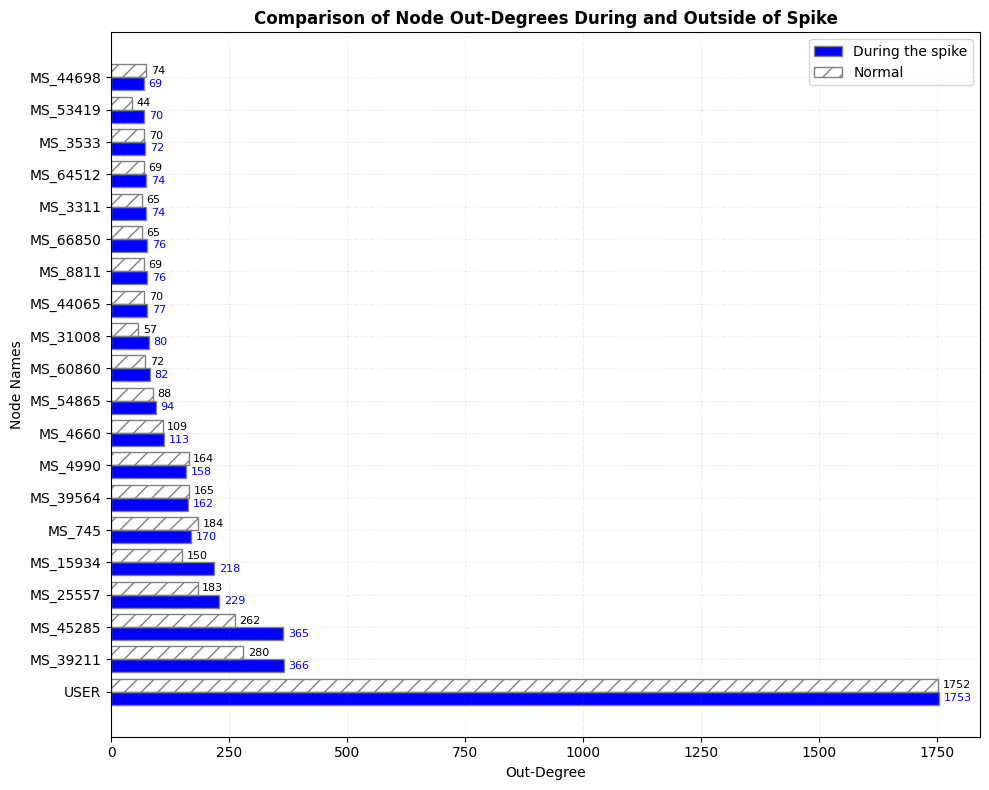

In [9]:
import numpy as np

start_time = 85860000 # Minute 891
end_time = 85860000 + 120000 # Minute 893

g_spike = gc_subgraph.window(start_time, end_time)

# 1. Retrieve all nodes and their out-degrees
nodes_out_degrees = [(node.name, node.out_degree()) for node in g_spike.vertices]

# 2. Sort nodes by their out-degree in descending order
sorted_nodes = sorted(nodes_out_degrees, key=lambda x: x[1], reverse=True)

# 3. Select the top 10 nodes
top_10_nodes = sorted_nodes[:20]

start_time = 83400000 # Minute 850
end_time = 83400000 + 120000 # Minute 852

g_no_spike = gc_subgraph.window(start_time, end_time)

# Retrieve all nodes in the second subgraph as a dictionary for quick access
nodes_in_no_spike = {node.name: node for node in g_no_spike.vertices}

# Initialize a list to store the comparison results
comparison_results = []

# Iterate over the top 10 nodes identified in the first subgraph
for name, spike_out_degree in top_10_nodes:
    # Check if the node exists in the second subgraph
    if name in nodes_in_no_spike:
        # Retrieve the node's out-degree in the second subgraph
        new_out_degree = nodes_in_no_spike[name].out_degree()
        # Store the comparison
        comparison_results.append((name, spike_out_degree, new_out_degree))
    else:
        # If the node doesn't exist in the second subgraph, note it as not found
        comparison_results.append((name, spike_out_degree, "Not found in second subgraph"))

names = []
spike_out_degrees = []
normal_out_degrees = []

for name, spike_out_degree, new_out_degree in comparison_results:
    names.append(name)
    spike_out_degrees.append(spike_out_degree)
    normal_out_degrees.append(new_out_degree)

fig, ax = plt.subplots(figsize=(10, 8))
r = np.arange(len(names))
r1 = r
r2 = [x + 0.4 for x in r]

# Make the plot
ax.barh(r1, spike_out_degrees, color='blue', height=0.4, label='During the spike', edgecolor='grey')
ax.barh(r2, normal_out_degrees, color='none', height=0.4, label='Normal', edgecolor='grey', hatch='//')

# Add x,y gridlines
ax.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

# Add annotation to bars
for i in range(len(names)):
    # Positioning the text on the right end of the bar
    ax.text(spike_out_degrees[i] + 10, i, str(spike_out_degrees[i]), va='center', color='blue', fontsize=8)
    ax.text(normal_out_degrees[i] + 10, i + 0.4, str(normal_out_degrees[i]), va='center', color='black', fontsize=8)

# Add x, y axis labels
plt.xlabel('Out-Degree')
plt.ylabel('Node Names')

# Add legend
plt.legend()

# Add titles and labels
plt.yticks([r + 0.2 for r in range(len(names))], names)
plt.title('Comparison of Node Out-Degrees During and Outside of Spike', fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()